# ChessR network training

## Configuration

In [5]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100})

### Modules

In [ ]:
# Installing necessary modules
!pip install --upgrade pip
!pip install tqdm
!pip install gdown
!pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import tqdm

### Constants

In [8]:
DATA_URL = "https://drive.google.com/file/d/192Px9a5_LB_d1fRKK68ID_luRCMRhy3B/view?usp=sharing"
DATA_FILENAME = "data.zip"
DATA_FOLDER = "data"
UNWRAPPED_IMAGES_FOLDER = "data/unwrapped"
CONFIG_FILE_PATH = os.path.join(DATA_FOLDER, "config.json")
IMAGE_SIZE = 128
BATCH_SIZE = 8
VAL_PROPORTION = 0.2
IMAGE_GROWTH_FACTOR = 0.1

### Downloading the data

In [7]:
# Checking that the data has not been downloaded yet
if os.path.exists(DATA_FILENAME):
  print("File already exists, skipping download.")
else:
  # Downloading the data
  if DATA_URL.split("/")[2] == "drive.google.com":
    print("Detected Google Drive link for the data.")
    dataGdriveId = DATA_URL.split("/")[5]
    print("Downloading...")
    !gdown --id $dataGdriveId --output $DATA_FILENAME
    if not os.path.exists(DATA_FILENAME):
      raise Exception("Could not download the data from Google Drive. Maybe too many downloads ?")
  else:
    raise Exception("Downloading from sources other than Google Drive not supported yet.")
    #!curl -o data.zip DATA_URL

Detected Google Drive link for the data.
Downloading...
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=192Px9a5_LB_d1fRKK68ID_luRCMRhy3B 



Exception: Could not download the data from Google Drive. Maybe too many downloads ?

### Unzipping into an appropriate folder

In [ ]:
if not os.path.exists(DATA_FOLDER):
  os.makedirs(DATA_FOLDER)
print("Unzipping downloaded data")
!unzip $DATA_FILENAME
!rm $DATA_FILENAME

## Extracting the renders config

In [ ]:
# Loading the types of pieces represented, as well as the cells and their coordinates
config = json.load(open(CONFIG_FILE_PATH, "r"))
piecesTypes = config['piecesTypes']
cellsCoordinates = config['cellsCoordinates']
cellsNames = list(cellsCoordinates.keys())

# Finding the extent of the board
minCoords = np.array([np.inf, np.inf])
maxCoords = np.array([-np.inf, -np.inf])
for cellName in cellsCoordinates:
  minCoords = np.minimum(minCoords, cellsCoordinates[cellName])
  maxCoords = np.maximum(maxCoords, cellsCoordinates[cellName])

boardSize = (maxCoords - minCoords + np.array([1.0, 1.0])).astype(int)

marginsSize = np.array([1.0, 1.0]) * IMAGE_SIZE * IMAGE_GROWTH_FACTOR * 0.5
cellSize = (IMAGE_SIZE - 2.0 * marginsSize) / boardSize
cellRelSize = (1.0 - IMAGE_GROWTH_FACTOR) / boardSize

print("Cells names : ", cellsNames)
print("Pieces types : ", piecesTypes)
print("Board size : ", boardSize) 

## Extracting the board images

In [ ]:
# IO functions for the images and data
def getUnwrappedImagePath(imgNum):
    return os.path.join(UNWRAPPED_IMAGES_FOLDER, "{}_unwrapped.jpg".format(imgNum))

def getImageConfigPath(imgNum):
    return os.path.join(DATA_FOLDER, "{}.json".format(imgNum))

def getRawImagePath(imgNum):
    return os.path.join(DATA_FOLDER, "{}.jpg".format(imgNum))

In [25]:

# Testing the creation of tfrecord objects
testDic = {
    "class" : tf.train.Feature(int64_list=tf.train.Int64List(value=[1])),
    "img" : tf.train.Feature(bytes_list=tf.train.BytesList(value=[open("test/23_A1_bishop_b.jpg", "rb").read()]))
}

with tf.io.TFRecordWriter("test.txt") as writer:
    tfrec = tf.train.Example(features=tf.train.Features(feature=testDic)).SerializeToString()
    
    writer.write(tfrec)

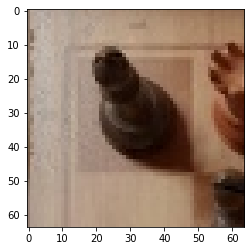

In [31]:
# Testing the creation of a dataset consuming TFRecords
def decodeTfRecord(record):
    features = {
        "class" : tf.io.FixedLenFeature([], tf.int64),
        "img" : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(record, features)
    img = example["img"]
    img = tf.image.decode_jpeg(img, channels = 3)
    return example["class"], img

dataset = tf.data.TFRecordDataset(["test.txt"])
dataset = dataset.map(decodeTfRecord)

imgClass, img = next(iter(dataset))
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
"""
The images all contain pictures of a chess board at a somewhat overlooking angle. 
This is not likely to work for the model, which needs data to be in a very similar format.
We thus wrap the images into new ones where the corners of the board match the corner of the image, with a given scaling factor
"""

if not os.path.exists(UNWRAPPED_IMAGES_FOLDER):
  os.makedirs(UNWRAPPED_IMAGES_FOLDER)

def getSegmentsIntersection(a1, a2, b1, b2):
    """
    Computes the intersection of two segments : returns the intersection point if it exists, and None otherwise
    """
    a = a2 - a1
    b = b2 - b1
    o = a1 - b1
    aLenSq = np.dot(a, a)
    aDotB = np.dot(a, b)
    denom = (aLenSq * np.dot(b, b)) - aDotB**2.0

    if denom == 0.0:
        # The segment are parallel, no unique intersection exists
        return None

    u = ((aLenSq * np.dot(b, o)) - (aDotB * np.dot(a, o))) / denom

    if u < 0.0 or u > 1.0:
        # The potential intersection point is not situated on the segment, aborting
        return None

    t = np.dot(a, u * b - o) / aLenSq
    aPoint = a1 + t * a
    bPoint = b1 + u * b

    return aPoint if (np.linalg.norm(np.round(aPoint - bPoint), 5) == 0.0) else None

def unprojectCropFromRelativeCoords(img_, boardCornersRel, outputShape, growthFactor = 0.0):
    O = getSegmentsIntersection(boardCornersRel[0], boardCornersRel[3], boardCornersRel[1], boardCornersRel[2])
    for i in range(4):
        boardCornersRel[i] = growthFactor * (boardCornersRel[i] - O) + boardCornersRel[i]

    cornersAbs = np.round(boardCornersRel * (np.array(img.shape)[0:2] - np.array([1.0, 1.0])))

    outCoords = np.array([
        [outputShape[0]-1, 0.0],
        [outputShape[0]-1, outputShape[1]-1],
        [0.0, 0.0],
        [0.0, outputShape[1]-1],
    ])

    inCoords = np.float32(cornersAbs)
    outCoords = np.float32(outCoords)
    M = cv2.getPerspectiveTransform(inCoords, outCoords)

    return cv2.warpPerspective(img_, M, outputShape, flags=cv2.INTER_LINEAR)

def getCellCenterRel(cellX, cellY):
    return np.zeros(2) + (IMAGE_GROWTH_FACTOR * 0.5) + np.array([0.5 + cellX, 0.5 + cellY]) * cellRelSize

def getCellExtentsRel(cellX, cellY):
    cellCenter = getCellCenterRel(cellX, cellY)
    newExtents = np.dot(np.array([-0.5, 0.5]).reshape((2,1)), (cellRelSize + IMAGE_GROWTH_FACTOR).reshape((1,2)))
    return cellCenter + newExtents

# Getting all the images in the data folder
imagesFiles = [file for file in os.listdir(DATA_FOLDER) if re.match(r'\d*.jpg', file) != None]

# Applying the uncropping on every images
for imgName in tqdm.tqdm(imagesFiles):
    imgNum = re.match(r'(\d*).jpg', imgName).group(1)
    imgPath = getRawImagePath(imgNum)
    annotationsPath = getImageConfigPath(imgNum)

    annotations = json.load(open(annotationsPath, "r"))

    img = cv2.imread(imgPath)

    # Getting the annotated board corners
    cornersRel = np.array(annotations["corners"])
    # Adapting them to the coordinate space in cv2
    cornersRel = np.column_stack((cornersRel[:,0], 1.0 - cornersRel[:,1]))
    
    ## Extracting the unwrapped board image 
    # Setting its size so that 
    boardImgSize = np.ceil((boardSize * IMAGE_SIZE)/(1.0 + IMAGE_GROWTH_FACTOR * (boardSize - 1.0))).astype(int)
    
    boardImage = unprojectCropFromRelativeCoords(img, cornersRel, boardImgSize, IMAGE_GROWTH_FACTOR)
    
    #plt.figure(figsize=(12,8), dpi= 100)
    #plt.imshow(boardImage)
    #plt.show()
    
    # Extracting the cell images
    for cellName in cellsCoordinates:
        cellCoords = cellsCoordinates[cellName]
        cellBoundsRel = getCellExtentsRel(cellCoords[0], cellCoords[1])
        cellBoundsAbs = np.round(np.multiply(cellBoundsRel.T, boardImgSize)).astype(int)
        
        pieceImg = boardImage[cellBoundsAbs[0,0]:cellBoundsAbs[0,1],cellBoundsAbs[1,0]:cellBoundsAbs[1,1]]
        
        pieceType = None if (not (cellName in annotations["config"])) else annotations["config"][cellName]
        #print("Printing cell {} who represents a {}".format(cellName, pieceType))
        #plt.imshow(pieceImg)
        #plt.show()
        
        cv2.imwrite(os.path.join("test", "{}_{}_{}.jpg".format(imgNum, cellName, pieceType)),  pieceImg)
    break
    #cv2.imwrite(getUnwrappedImagePath(imgNum),  boardImage)


## Formatting the labels into numpy arrays

In [ ]:
def numpyArrayFromLabelFile(labelFilePath):
  """
  Builds a 3D numpy array of 0 and 1 representing the labels for the board
  Each column represents a cell and has exactly one 1, whose position corresponds to a certain type of piece
  """
  ret = np.zeros((boardSize[0], boardSize[1], len(piecesTypes)))
  labelRawData = json.load(open(labelFilePath, 'r'))
  piecesConfig = labelRawData['config']

  for cellName in cellsNames:
    cellCoordinate = cellsCoordinates[cellName]
    if cellName in piecesConfig:
      ret[cellCoordinate[0], cellCoordinate[1], piecesTypes.index(piecesConfig[cellName])] = 1
    
  return ret.astype(np.float32)

## Building the data pipeline

In [10]:
#Loading tensorflow, checking that we have a GPU allocated
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

2022-02-12 16:36:14.086928: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 16:36:14.108648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 16:36:14.114024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 16:36:14.114314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
def loadImageTensor(imageFilePath):
    imgData = tf.io.read_file(imageFilePath)
    img = tf.io.decode_jpeg(imgData, channels=3)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

    return img

def formatData(imageFilePath, label):
  return loadImageTensor(imageFilePath), label

def makeDataset(imagesFilesPaths, imagesLabels):
  """
  Makes a dataset from the unwrapped images and their labelled data paths, and returns the input image and the labels matrix
  """
  dataset = tf.data.Dataset.from_tensor_slices((inputImagesPath, imagesLabels))

  dataset = dataset.map(formatData, num_parallel_calls = tf.data.AUTOTUNE)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

## Preparing slices
# Storing the paths of images 
print("Preparing data slices")
inputImagesPath = [os.path.join(UNWRAPPED_IMAGES_FOLDER, filename) for filename in os.listdir(UNWRAPPED_IMAGES_FOLDER)]
imgsNums = [int(re.search(r'(\d+).+?(?=\.)', filename).group(1)) for filename in inputImagesPath]
imagesLabels = [numpyArrayFromLabelFile(getImageConfigPath(imgNum)) for imgNum in imgsNums]

inputImagesPath = tf.constant(inputImagesPath)
imagesLabels = tf.constant(imagesLabels)

print("Creating datasets")
datasetSize = len(inputImagesPath)
sepPoint = int(datasetSize * (1.0 - VAL_PROPORTION) / BATCH_SIZE)

fullDs = makeDataset(inputImagesPath, imagesLabels)
trainDs = fullDs.take(sepPoint)
valDs = fullDs.skip(sepPoint)

images, labels = next(iter(trainDs))
plt.figure()
plt.imshow(images[0])
plt.show()

images, labels = next(iter(valDs))
plt.figure()
plt.imshow(images[0])
plt.show()


## Building the model architecture

### Custom loss

In [ ]:
def labelsPredLoss(y_true, y_pred):
  """
  Custom loss. Returns the minimum difference between the predicted labels and 
  """
  loss = tf.reduce_mean(tf.math.squared_difference(tf.experimental.numpy.rot90(y_true, axes=(1,2), k=0), y_pred))
  for i in range(1, 4):
    diff = tf.reduce_mean(tf.math.squared_difference(tf.experimental.numpy.rot90(y_true, axes=(1,2), k=i), y_pred))
    loss = tf.minimum(diff, loss)
  
  return loss

### Model architecture

In [ ]:
# Loading pretrained layer
#denseNet121 = tf.keras.applications.DenseNet121(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling="max")
#resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling="max")
#vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),pooling="max")
mobileNetv2 = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),include_top=False,weights="imagenet",pooling="max")
pretrainedLayer = mobileNetv2
pretrainedLayer.trainable = True

In [ ]:
# Early stopping setup
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-3)

# Model building
model = tf.keras.Sequential()

model.add(pretrainedLayer)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(8*8*13, name="output", activation="sigmoid"))
model.add(tf.keras.layers.Reshape((8,8,13)))

model.compile(optimizer = 'adam', 
              loss = labelsPredLoss)

model.summary()

## Training

In [ ]:
def trainModel():
  history = None
  with tf.device("/device:GPU:0"):
    history = model.fit(trainDs, epochs = 20, validation_data = valDs, callbacks=[callback])
  return history

history = None
history = trainModel()

In [ ]:
plt.plot(np.array(history.history['loss']))
plt.plot(np.array(history.history['val_loss']))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(ymax = 0.1, ymin = 0.0)
plt.legend(["Training", "Validation"])
plt.show()

## Testing on test data

In [ ]:
imgNum = 128
img = loadImageTensor(getUnwrappedImagePath(imgNum))
a = model.predict(valDs)[0]

In [ ]:
np.argmax(a, axis = 2)